The goal of this notebook is to write some useful functions that will allow us to analyze protein binding microarray data to see if hypercooperativity occurs in non-yeast TFs.  

Code written by RDM 

## Finding a consensus motif in a sequence

The first thing we want to do is write a function, FindConsensusMotif, that takes as input a "consensus motif", which is essentially a consensus sequence, but with Ns,Rs,Ys,Ks, and a sequence to scan.  It will scan the sequence and return a list of lists that give the start and stop coordinates of all instances of the consensus motif, on both strands of course.

In [1]:
import Bio
from Bio.Seq import Seq
from Bio.Alphabet.IUPAC import unambiguous_dna, ambiguous_dna
from Bio import SeqUtils

def FindConsensusMotif(consensusMotif,input_sequence):
    
    ''' This function takes as input a "consensus motif", which is essentially a consensus sequence,
    but with Ns,Rs,Ys,Ks, and a sequence to scan. It will scan the sequence and return 
    a list of tuples that give the start and stop coordinates of all instances of the 
    consensus motif, on both strands of course.
    
    The consensusMotif variable can be passed to this function a string or a Seq object 
    The input_sequence variable can also be baseed as a string or Seq object'''

    input_sequence = Seq(str(input_sequence),ambiguous_dna)
    consensusMotif = Seq(str(consensusMotif),ambiguous_dna)
    
    #find all instances of consensus motif in forward strand of the sequence
    start_positions_forward = SeqUtils.nt_search(str(input_sequence), str(consensusMotif))[1:]
    
    #find all instances of consensus motif in the reverse strand of the sequence
    
    #first, take the reverse complement of the consensus motif
    rc_consensusMotif = consensusMotif.reverse_complement()
    
    if rc_consensusMotif == consensusMotif: #if consensusMotif is palindromic, don't search reverse strand
        end_positions_reverse = []
    else:
        end_positions_reverse = SeqUtils.nt_search(str(input_sequence), str(rc_consensusMotif))[1:]
    
    #output list of lists giving start and end positions of all motif 
    #instances.  For instance on the forward strand, start < end.  
    #For reverse strand, start > end.  The indices are zero indexed.
    output_list = []
    for startpos in start_positions_forward:
        position_list = [startpos,startpos+len(consensusMotif)-1]
        output_list.append(position_list)
    
    for endpos in end_positions_reverse:
        position_list = [endpos+len(consensusMotif)-1,endpos]
        output_list.append(position_list)
    
    return output_list
        
    

Now let's test the function to make sure that it works:

In [2]:
FindConsensusMotif("TTAA","TTAACAATCCAATTCC")

[[0, 3]]

In [3]:
FindConsensusMotif("CGG","TTACAATCCAATTCCGG")

[[14, 16], [15, 13]]

*The function appears to work*

## Counting sites from output of *FindConsensusMotif* 

The next step is to write two functions that count the number of instances of a given motif in a sequence.  The first just reports the number of sites.  The second reports the maximal number of non-overlapping sites. How do we find this?  This is the "maximal disjoint intervals" problem, and the solution is listed on geeksforgeeks.org:

1.  Sort the intervals, with respect to their end points.
2.  Now, traverse through all the intervals, if we get two overlapping intervals, then greedily choose the interval with lower end point since, choosing it will ensure that intervals further can be accommodated without any overlap.
3.  Apply the same procedure for all the intervals and print all the intervals which satisfy the above criteria.

In [4]:
def countSites(hit_list):
    return len(hit_list)

def countSites_maxdisjoint(hit_list):
    #we no longer need the strand information
    #and we need the coordinates to be in smallest
    #to largest order to properly sort the intervals
    #for the maximal disjoint intervals problem.
    #so first step is to make sure all coordinates
    #are smallest to largest
    
    for index,sublist in enumerate(hit_list):
        hit_list[index].sort()
    
    #now sort by endpoint
    
    hit_list = sort_hitlist_by_endpoint(hit_list)
    
    index = 0
    while index < len(hit_list)-1:
        #print(hit_list) uncomment this print for debugging
        #does the nth element overlap the n+1 th element?
        if hit_list[index][1] >= hit_list[index+1][0]:
            #if there is overlap, then find
            #which element has the smaller end coordinate
            if hit_list[index][1] <= hit_list[index+1][1]:
                #remove n+1th element, don't advance index
                hit_list.pop(index+1)
            else:
                #remove nth element, don't advance index
                hit_list.pop(index)
        else:
            #if there is no overlap, advance the index
            index = index + 1
    return len(hit_list)
   
    
def sort_hitlist_by_endpoint(hit_list): 
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    hit_list.sort(key = lambda x: x[1]) 
    return hit_list

In [5]:
countSites(FindConsensusMotif("AR","TTACAATCCAATTCC"))

4

In [6]:
hit_list = [[1, 3], [4, 2], [6, 4], [12, 11],[9,3]]

In [7]:
countSites(hit_list)

5

In [8]:
countSites_maxdisjoint(hit_list)

3

*These functions appear to work*

## Writing a program to analyze PBM data

There are number of different formats for PBM data.  I think the easiest thing to do is write the functions to handle files that have two columns, one that gives the binding score, the second, the sequence.  This is the format that the Bulyk lab has a lot of their data in, and in instances where it is not, the raw data can be relatively easily converted to this format by awk or the like.

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style("ticks")
sns.set_context('notebook') #must be in 'paper', 'notebook', 'talk', 'poster'

def compute_binding_v_sites(filename,consensus_site,tf_name,  canonical_site = "N/A", median=False,overlapping_sites=False,path = "PBM_data/"):
    
    PBMframe = pd.read_csv(filename,sep="\t",header=None,names=["binding_score","sequence"])
    
    if canonical_site != "N/A":
        PBMframe = remove_canon(PBMframe,canonical_site)
    if overlapping_sites:
        PBMframe["num_sites"] = PBMframe.sequence.apply(lambda x: countSites(FindConsensusMotif(consensus_site,x)))
    else:
        PBMframe["num_sites"] = PBMframe.sequence.apply(lambda x: countSites_maxdisjoint(FindConsensusMotif(consensus_site,x)))


    if median:
        #PBMframe = PBMframe.loc[PBMframe["num_sites"]< 8]
        return PBMframe.groupby("num_sites").median(),PBMframe.groupby("num_sites").count(),PBMframe
    
    return PBMframe
#     else:
#         return PBMframe.groupby("num_sites").mean(),PBMframe

def remove_canon(PBMframe,canonical_site):
    PBMframe["canonical_sites"] = PBMframe.sequence.apply(lambda x: countSites(FindConsensusMotif(canonical_site,x)))
    #return PBMframe
    PBMframe = PBMframe[PBMframe["canonical_sites"]==0]
    del PBMframe["canonical_sites"]
    return PBMframe

def plot_PBM_data(sites_v_score_frame,suptitle="TF binding",title="Binding to TF half sites"):
    fig = plt.figure()
    fig.suptitle(suptitle, fontsize='large', fontweight='bold')
    fig.subplots_adjust(top=0.87)
    #This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
    #This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.

    ax = fig.add_subplot(111)
    hfont = {'fontname':'Arial'}
    fontdict={'fontsize': 14,
        'fontweight' : 'book',
        'verticalalignment': 'baseline',
        'horizontalalignment': 'center'}

    ax.set_title(title, fontdict=fontdict)
    #This specifies which plot to add the customizations. fig.add_sublpot(111) corresponds to top left plot no.1 
    #(there is only one plot). 

    plt.plot(sites_v_score_frame, 'go-',markersize = 10,linewidth=2,color = "darkred") #linewidth=1 to make it narrower
    plt.xlabel('Number of Sites', fontsize=14, **hfont)
    plt.ylabel('Binding Score', fontsize=14, **hfont)
    #plt.show()
    plt.savefig('')
    


In [87]:
[output,two, frame] = compute_binding_v_sites("Cbf1-9_deBruijn.txt","CAC","Cbf1",median=True)
#[output,frame] = compute_binding_v_sites("Gal4-11_deBruijn.txt","CGG","TTATNTCCGN",median=True)

In [88]:
output

,binding_score
num_sites,
2,5852.058658
3,6636.045807
4,7822.231518
5,9150.551236
6,11698.370899
7,18724.549476
8,18616.696122


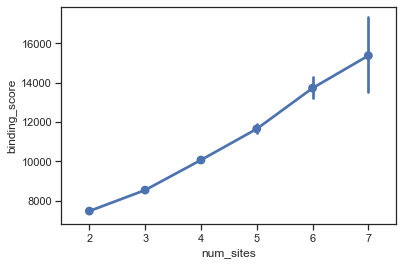

In [86]:
#>>> sns.set_theme(style="darkgrid")
#>>> tips = sns.load_dataset("tips")
frame2 = frame[frame["num_sites"] < 8] 
ax = sns.pointplot(x="num_sites", y="binding_score", data=frame2)

In [101]:
[output, frame] = compute_binding_v_sites("Leu3_deBruijn.txt", "CGG", "CCGGNNNCGG", median=True)


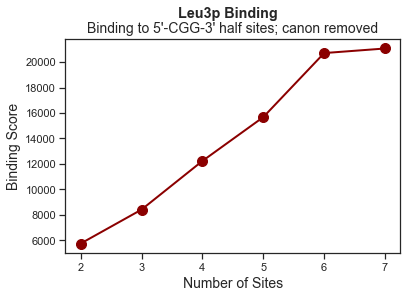

In [102]:
plot_PBM_data(output, "Leu3p Binding", "Binding to 5\'-CGG-3\' half sites; canon removed")

In [104]:
[output,frame] = compute_binding_v_sites("Gal4-11_deBruijn.txt", "CGG", "CGGNNNNNNNNNNNCCG", median=True)



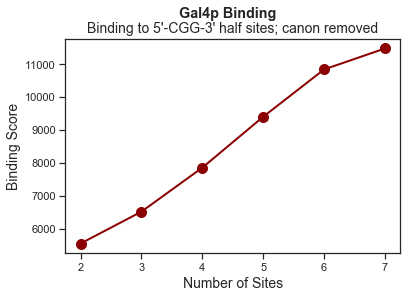

In [105]:
plot_PBM_data(output, "Gal4p Binding", "Binding to 5\'-CGG-3\' half sites; canon removed")

In [107]:
[output,frame] = compute_binding_v_sites("Put3-9_deBruijn.txt", "CGG", "CGGNNNNNNNNNNCCG", median=True)



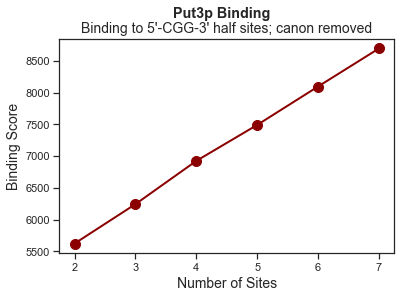

In [108]:
plot_PBM_data(output, "Put3p Binding", "Binding to 5\'-CGG-3\' half sites; canon removed")

In [114]:
[output,frame] = compute_binding_v_sites("Ecm22_deBruijn.txt", "CGG", "CGGNNNNNCGG", median=True)



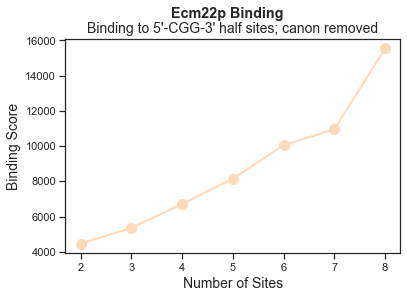

In [118]:
plot_PBM_data(output, "Ecm22p Binding", "Binding to 5\'-CGG-3\' half sites; canon removed")

In [110]:
[output,frame] = compute_binding_v_sites("Cha4_deBruijn.txt", "CGG", "CGGNNNNNNNNNNNNGA", median=True)



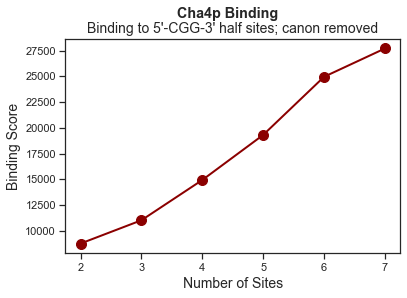

In [111]:
plot_PBM_data(output, "Cha4p Binding", "Binding to 5\'-CGG-3\' half sites; canon removed")